In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np


In [7]:
EPOCHS = 500
BATCH_SIZE = 100
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
print("Using Device:",DEVICE)

Using Device: cuda


In [35]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [18]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

In [19]:
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256 ,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [20]:
D = D.to(DEVICE)
G = G.to(DEVICE)

In [21]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

In [39]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0154, g_loss: 7.8831, D(x): 0.99, D(G(z)): 0.00
Epoch [1/500], d_loss: 0.1181, g_loss: 5.3078, D(x): 0.97, D(G(z)): 0.02
Epoch [2/500], d_loss: 0.1852, g_loss: 4.1749, D(x): 0.97, D(G(z)): 0.06
Epoch [3/500], d_loss: 0.2483, g_loss: 4.2492, D(x): 0.93, D(G(z)): 0.03
Epoch [4/500], d_loss: 0.1099, g_loss: 4.7287, D(x): 0.95, D(G(z)): 0.03
Epoch [5/500], d_loss: 0.1540, g_loss: 5.2416, D(x): 0.97, D(G(z)): 0.06
Epoch [6/500], d_loss: 0.5385, g_loss: 4.6482, D(x): 0.88, D(G(z)): 0.02
Epoch [7/500], d_loss: 0.1607, g_loss: 5.1017, D(x): 0.95, D(G(z)): 0.04
Epoch [8/500], d_loss: 0.1327, g_loss: 5.1198, D(x): 0.96, D(G(z)): 0.06
Epoch [9/500], d_loss: 0.2980, g_loss: 4.4022, D(x): 0.91, D(G(z)): 0.08
Epoch [10/500], d_loss: 0.3017, g_loss: 3.7100, D(x): 0.96, D(G(z)): 0.17
Epoch [11/500], d_loss: 0.3080, g_loss: 3.5523, D(x): 0.89, D(G(z)): 0.05
Epoch [12/500], d_loss: 0.2429, g_loss: 4.0708, D(x): 0.93, D(G(z)): 0.09
Epoch [13/500], d_loss: 0.2931, g_loss: 4.8123, 

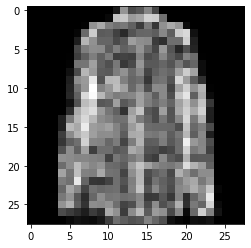

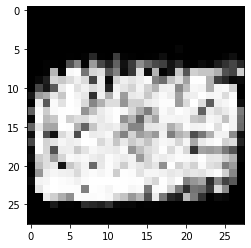

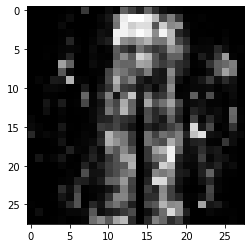

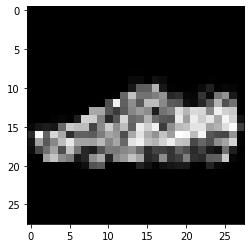

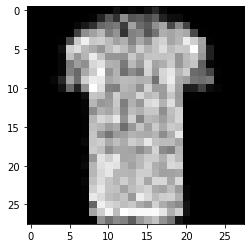

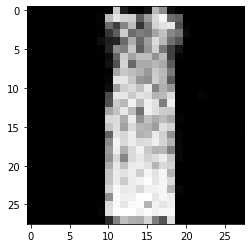

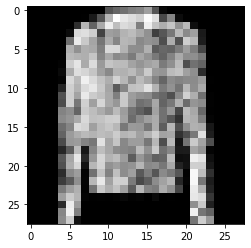

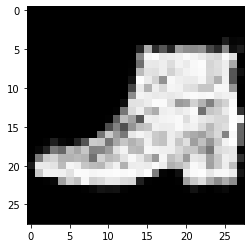

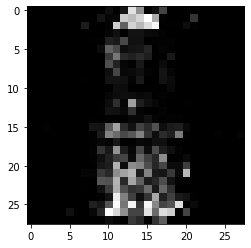

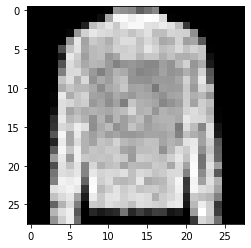

In [53]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
plt.imshow(fake_images.data.cpu().numpy())
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

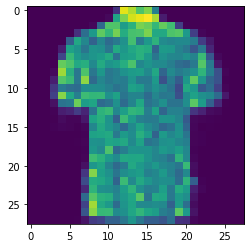

In [54]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')